In [252]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
sns.set() 

# Read in data
df = pd.read_csv("spotify-2023.csv", encoding='ISO-8859-1')

# Print first 5 rows
df.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [253]:
df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,67.812172,51.908709,2.666317,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,86.441493,50.630241,6.035599,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,13.000000,7.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,34.000000,38.000000,0.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,88.000000,87.000000,2.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,672.000000,275.000000,58.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


# Initial Describe #

# Dealing with Null/Missing Values #

We removed 'in_shazam_charts' because there were 50 null values as well the fact that we weren't going to use the column in our analysis. Additionally we found a large amount of NaN values in 'key', and so we decided to change those values into the string "Multiple Keys" because we decided to not look at songs with mutliple keys and this way we could maintain the data rows while still tracking the key of songs appropriately. 

In [254]:
# Checking for null values in "in_shazam_charts" column
print("Number of null values: " + str(df['in_shazam_charts'].isnull().sum()))

# drop shazam charts because of missing values / unnecessary for our analysis
df = df.drop(columns=['in_shazam_charts'], axis=1)

Number of null values: 50


In [255]:
# find the missing values in the dataset in the key column
missing_values_sum = df['key'].isna().sum()
print("Number of Missing Values: " + str(missing_values_sum))

# change NaN values to "Multiple Keys"
df['key'] = df['key'].fillna('Multiple Keys')

print(df['key'].value_counts(dropna=False))

Number of Missing Values: 95
C#               120
G                 96
Multiple Keys     95
G#                91
F                 89
B                 81
D                 81
A                 75
F#                73
E                 62
A#                57
D#                33
Name: key, dtype: int64


# Dealing With DataTypes #

We turned streams into an integer to make it easier to perform mathematical range operations on the data. We also removed commas from stream values to allow them to be compatible with a integer casting operation. 

In [256]:
# Check the datatypes and change if necessary
print(df.dtypes)

## Check for invalid Stream Values. 
for stream in df['streams']:
    try:
        int(stream)
    except ValueError:
        print(stream + ' is not an integer Value')

# delete line 576 row of the csv file because the streams value is a misinput, and without the actual streams count we can't impute
df = df[df['streams'] != 'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3']

# change streams column to integer
df['streams'] = df['streams'].apply(int)

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object
BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3 is not an integer Value


In [257]:
## Check for invalid Stream Values. 
invalid_streams = []
for stream in df['in_deezer_playlists']:
    try:
        int(stream)
    except ValueError:
        invalid_streams.append(stream)

# Check to see if there are any strings that we cannot convert to integers
print("Number of Invalid Stream values: " + str(len(invalid_streams)))

# Print the first 5 elements of the array to see what the strings look like
print("First 5 Invalid Streams :" + str(invalid_streams[:5]))

# Remove all commas in the strings (2,445 -> 2445) so we can cast to ints
df['in_deezer_playlists'].replace(',','', regex=True, inplace=True)

## Check for invalid Stream Values Again. 
invalid_streams = []
for stream in df['in_deezer_playlists']:
    try:
        int(stream)
    except ValueError:
        invalid_streams.append(stream)

# Check to see if there are any more invalid strings that we cannot convert to integers
print("New Number of Invalid Streams: " + str(len(invalid_streams)))
df['in_deezer_playlists'] = df['in_deezer_playlists'].apply(int)



Number of Invalid Stream values: 79
First 5 Invalid Streams :['2,445', '3,394', '3,421', '4,053', '1,056']
New Number of Invalid Streams: 0


# Exploring the Data #

## Understanding Streams ##

We visualized a histogram that showed the relationship between songs and streams. As we can see, the number of songs in the 0.0-0.5 billion streams range is the highest. The histogram is right skewed. The mean is 0.514 billion, the minimum is 2762 streams, and the max is 3.70 billion streams.

count    9.520000e+02
mean     5.141374e+08
std      5.668569e+08
min      2.762000e+03
25%      1.416362e+08
50%      2.905309e+08
75%      6.738690e+08
max      3.703895e+09
Name: streams, dtype: float64


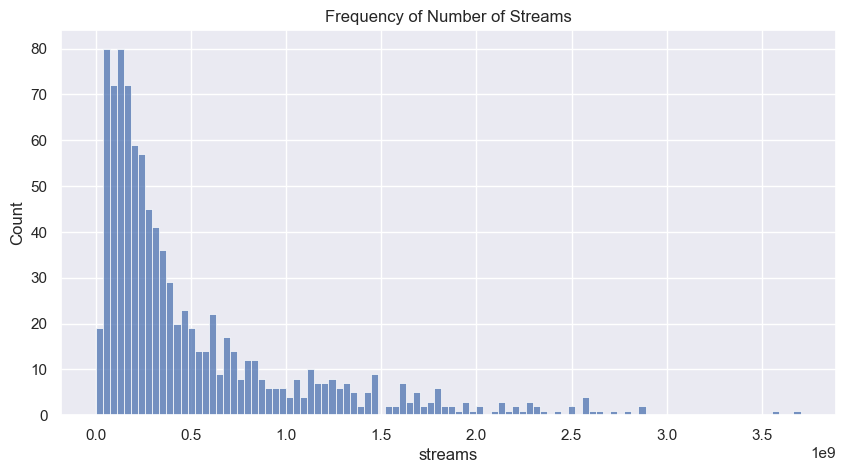

In [258]:
print(df['streams'].describe())

plt.figure(figsize=(10, 5)) 


sns.histplot(data=df['streams'], bins=100)
plt.title("Frequency of Number of Streams")
#display the created plot
plt.show()

## Do Artist Collabs Make A Difference? ##

We visualized a bar plot that shows the number of artists on a song and how many streams they had. Based on the distribution, it's pretty spread out and so it's hard to claim that there's a specific best number. Generally, the trend is that more artists is worse (except for 7) but this is likely due to more songs being made by 1 artist so there are more streams on 1 artist songs. 

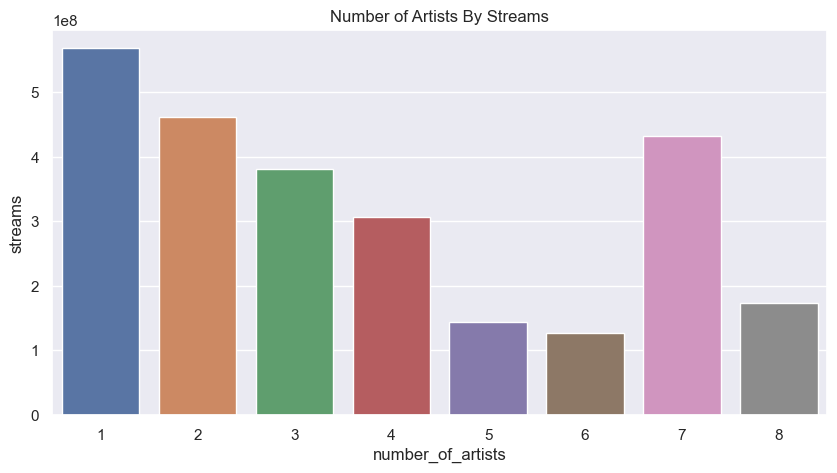

-0.1367994890523529


In [259]:
# Append a new column with the number of artists of the song
df['number_of_artists'] = df['artist(s)_name'].apply(lambda x: len(x.split(',')))

# Aggregate by the number of artists and calculate the mean streams
df_agg = df.groupby('number_of_artists').agg({'streams': 'mean'}).reset_index()

plt.figure(figsize=(10, 5))
# Plot the number of artists and the mean streams
sns.barplot(data=df_agg, x="number_of_artists", y="streams")
plt.title("Number of Artists By Streams")
plt.show()

# Correlation of number_of_artists and streams
print(df['number_of_artists'].corr(df['streams']))


## How does the Release Date Play a Role in Streams? ##

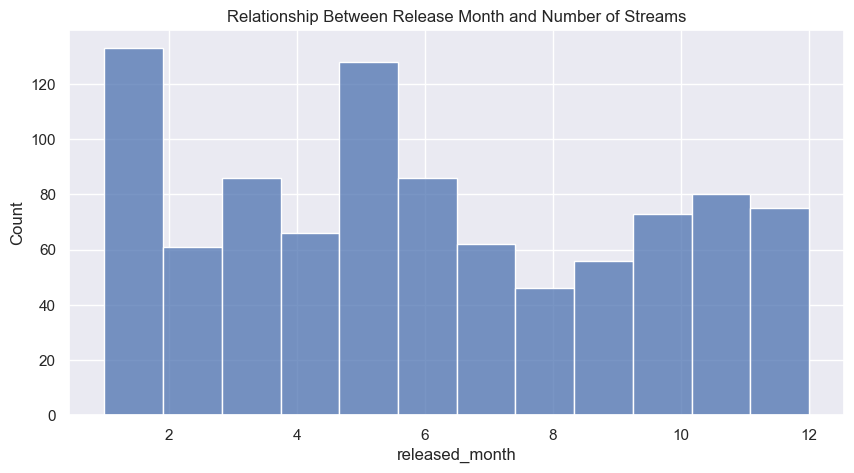

Release Month and Stream Number Correlation: -0.024937928598855272


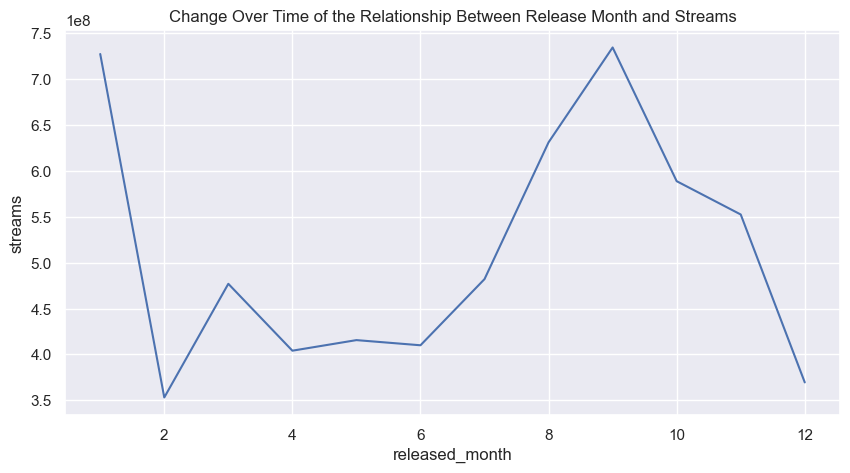

In [260]:
# Plot release date vs streams
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="released_month", bins=12)
plt.title("Relationship Between Release Month and Number of Streams")
plt.show()

# Correlation of release_date and streams
print("Release Month and Stream Number Correlation: " + str(df['released_month'].corr(df['streams'])))

# Aggregate to Find average stream per month
df_avg_streams_per_month = df.groupby('released_month')['streams'].mean().reset_index()

# Plot average streams per month
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_avg_streams_per_month, x='released_month', y='streams')
plt.title("Change Over Time of the Relationship Between Release Month and Streams")
plt.show()

## Analyzing Release Date data ##

By looking at our first graph we can see that music in our dataset is realeased slightly more in January and May. Otherwise music is generally released evenly throughout the year. Our second graph shows that the average number of streams by month greatly differs as music released in January and September tend to become the most popular (They have higher average streams, ~ 750 million streams for both). Additionally the average stream count is very low for December and Debuary (~350 million streams). Through this we believe the time of release for music has an impact on popularity and therefore we will use it as one of our explanatory variables. 

# Analyzing Song Characteristics #

Text(0.5, 0.92, 'Distribution of Song Characteristics')

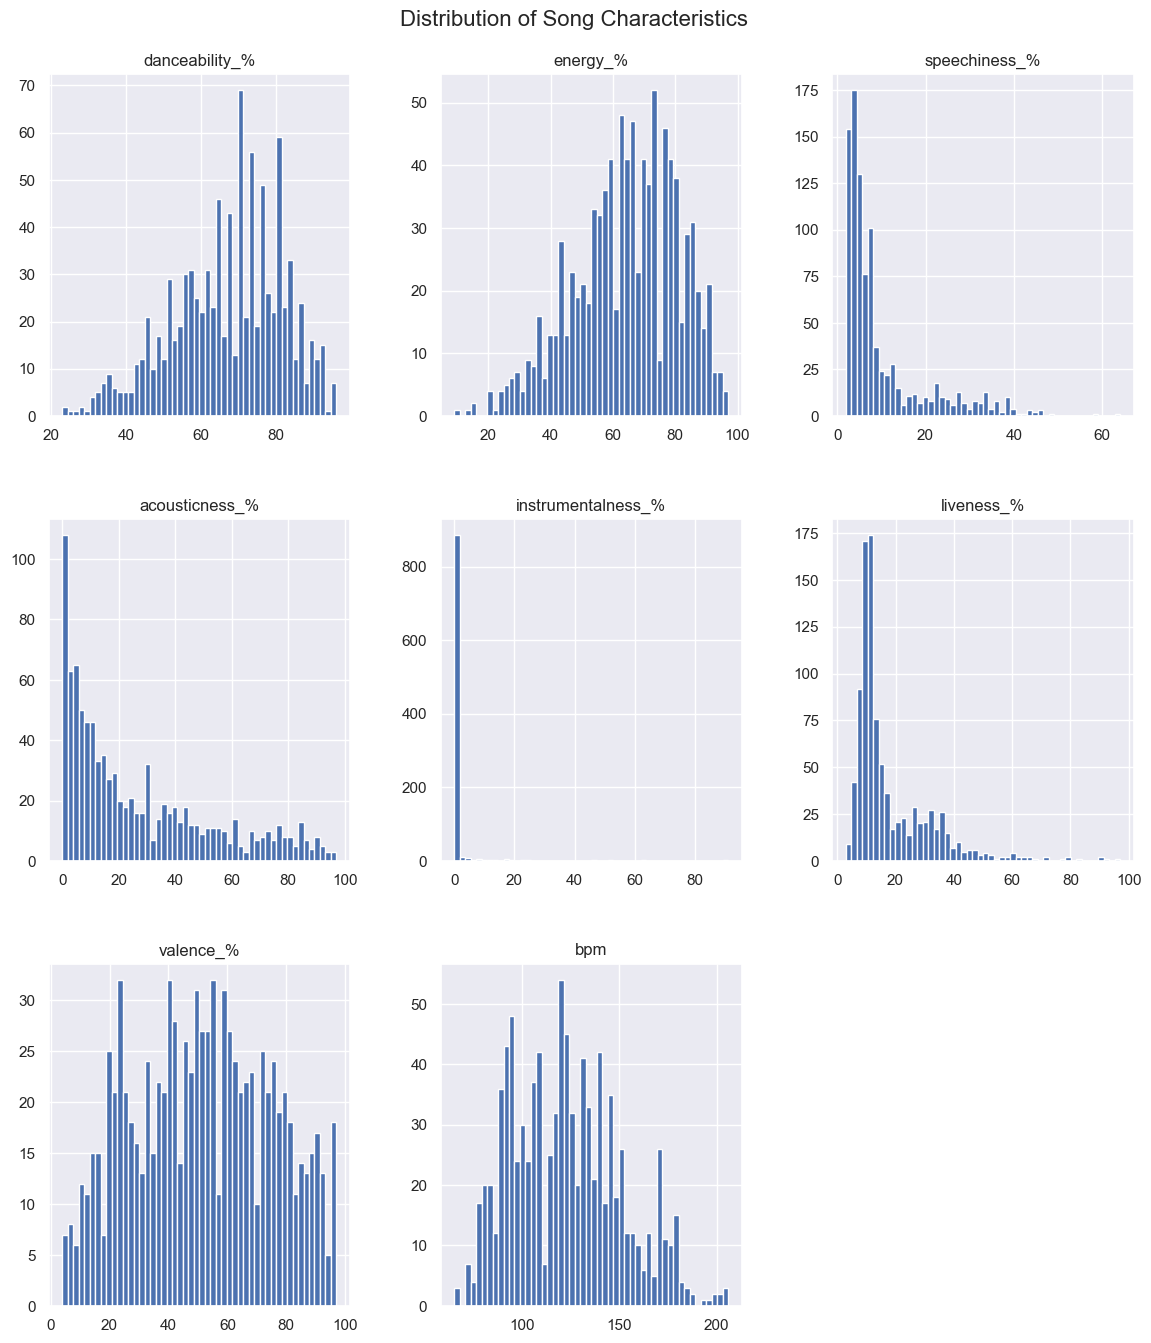

In [261]:
# Get all feature variable names that involve song charasteristics
song_characteristics = ['danceability_%', 'energy_%', 'speechiness_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'valence_%', 'bpm']

# Create a new dataframe with only the song characteristics
df_song_characteristics = df[song_characteristics]

# Plot the distributions of the song characteristics
df_song_characteristics.hist(figsize=(14, 16), bins=50)
plt.suptitle('Distribution of Song Characteristics', x=0.5, y=0.92, fontsize=16)

## Song Characteristics and thier Distributions ##

From looking at the Historgrams we notice the following

BPM: The BPM of the songs in our data are normally distributed with no extreme skew or glaring outliers.

Valence: Valence also is normally distributed with no glaring skew.

Liveness: Liveness does not vary much for the songs in our data set as the majority of songs are at around 10% liveness.

Acousticness: The Acousticness distribution has a strong right skew, as most songs have a low level of acousticness

Instrumentalness: Is not normally distributed, as an overwhelming majority of songs in our dataset have no instrumentalnes.

Speechiness: The majority of songs have low speechiness which is shown by the strong right skew in the histogram above for speechiness.

Energy: Energy is normally distributed with a slight left skew signaling that the songs in our dataset tend to be slightly more energetic.

Danceability: Similar to Energy, Danceability is normally distributed with a slight left skew showing that our data tends to have slightly more danceable music.

## Song Keys and Modes ##

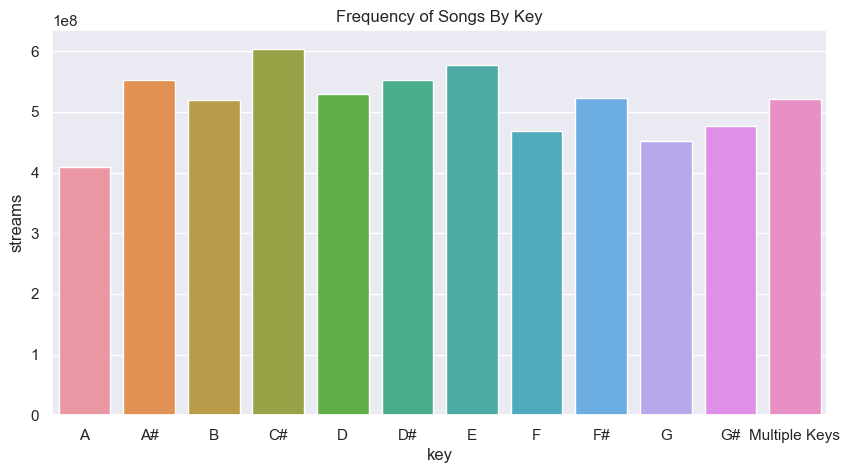

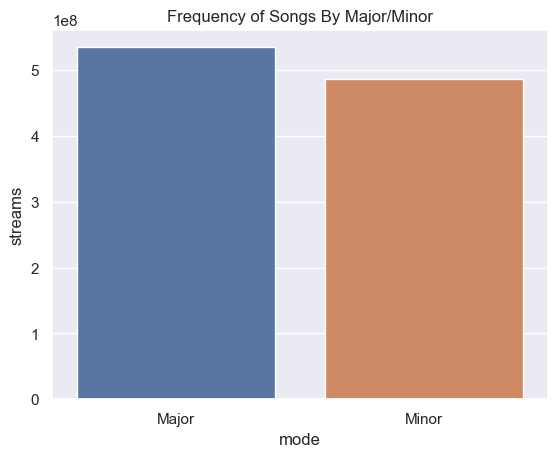

In [262]:
# Aggregate by Key value and find the average streams per key
df_avg_streams_per_key = df.groupby('key')['streams'].mean().reset_index()

# Plot average streams per key
plt.figure(figsize=(10, 5))
sns.barplot(data=df_avg_streams_per_key, x='key', y='streams')
plt.title("Frequency of Songs By Key")
plt.show()

# Aggregate by Mode
df_avg_streams_per_mode = df.groupby('mode')['streams'].mean().reset_index()
sns.barplot(data=df_avg_streams_per_mode, x='mode', y='streams')
plt.title("Frequency of Songs By Major/Minor")
plt.show()

## Musical Key and Mode Analysis ##

When we look at the first graph (average streams per key) we can see that C# appears to be the key that has the most average streams however generally it appears that the key does not have a large effect on streams as the averages seem to be similar to each other. We also know this by looking at the correlation between the Key and streams. Because of this we will not be including Key as one of our explanatory variables.

Similarly, when we look at the Mode of the song we can see that their is no large difference between the average streams for Major and Minor. We also will not use this as an explanatory variable as Mode does not appear to have an impact on the popularity of a song. 

In [263]:
# Set our Universal Random Seed
SEED = 7


# Modeling and Feature Selection #

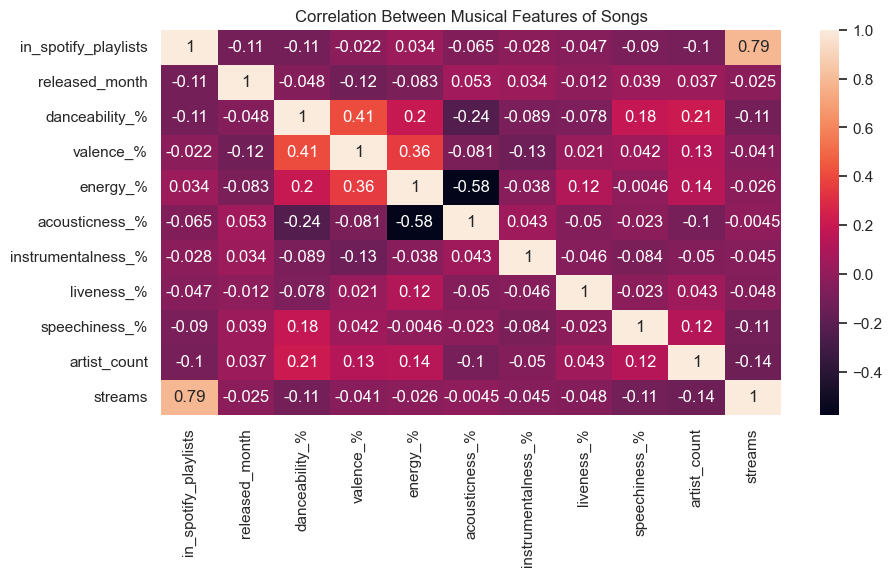

In [264]:
# Create a correlation matrix of the selected features

plt.figure(figsize=(10, 5))

sns.heatmap(df[['in_spotify_playlists', 'released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'artist_count', 'streams']].corr(), annot=True)
plt.title("Correlation Between Musical Features of Songs")
plt.show()

Through the Correlation Matrix we can see that none of the features have a clear correlation with the number of streams that a song gets aside from in_spotify_playlists. Through this it appears that songs that work well with others (playlistable) tend to gather more streams. This variable will play a large role in predicting the populartity of songs. Of the song characteristics we can see that speechiness, danceability, and artist count have the highest correlation but still very low. While they have a low correlation they still may help us in predicting the popularity of a song so they will be used. 

## Decision Tree Regression ##

In [265]:
# decision tree classifier
from sklearn.tree import DecisionTreeRegressor
#encode the categorical feature

print(df.shape)


X   = df[['in_spotify_playlists', 'artist_count', 'released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'instrumentalness_%', 'liveness_%', 'speechiness_%']] #get the input features
y   = df['streams']              #get the target


X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #streams
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=SEED,                             
                                                   )


accuracy_scores = {}

# Loop through different max_depths and get the accuracy scores
for i in range(2, 20, 2):
    # Create a Decision Tree Regressor with the current max_depth
    dt = DecisionTreeRegressor(max_depth=i, random_state=SEED)
    # Fit the model on the training data
    dt.fit(X_train, y_train)
    
    #get the classification report for the decision tree
    y_pred = dt.predict(X_test)

    # Calculate the mse and append it to the list of accuracy scores
    mse = mean_squared_error(y_test, y_pred)
    # Add the accuracy score with its asssociated mse value to the dictionary
    accuracy_scores[i] = mse

# Grab the max_depth with the lowest MSE
best_max_depth = min(accuracy_scores, key=accuracy_scores.get)

# Create a Decision Tree Regressor with the best max_depth
dt = DecisionTreeRegressor(random_state=SEED, max_depth=best_max_depth)
# Fit the model on the training data
dt.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = dt.predict(X_test)

# Calculate the mse
mse = mean_squared_error(y_test, y_pred).round(2)
# Get the r-squared value
r_squared = r2_score(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the best model is: {}'.format(mse))
print('The r-squared of the best model is: {}'.format(r_squared))
    


(952, 24)
The mse of the best model is: 1.0854914508754149e+17
The r-squared of the best model is: 0.6988354045555143


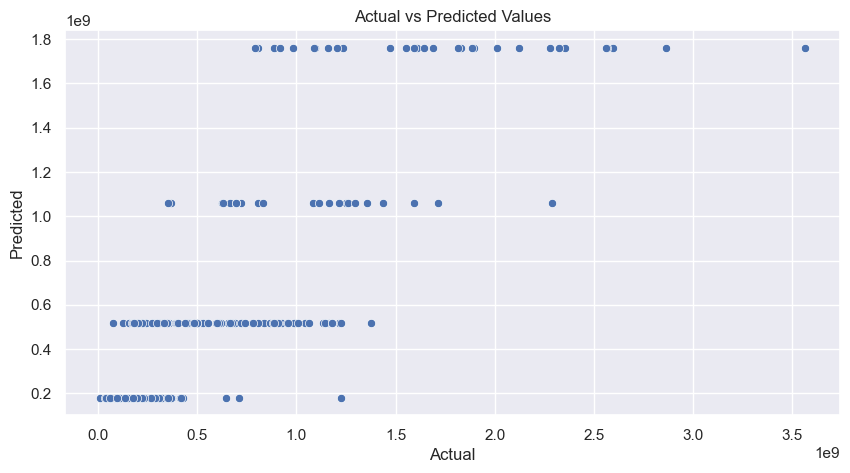

In [266]:
# Graph Actual vs Predicted Values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

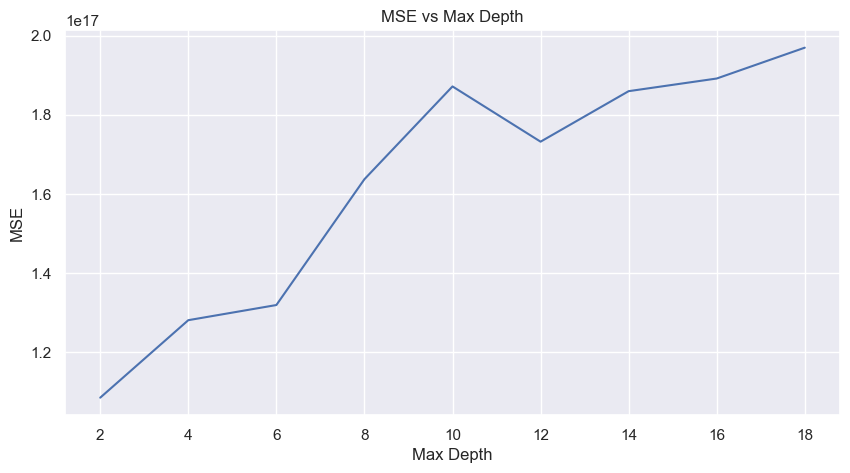

In [267]:
# Plot accuracy scores for each max_depth
plt.figure(figsize=(10, 5))
plt.plot(accuracy_scores.keys(), accuracy_scores.values())
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.title("MSE vs Max Depth")
plt.show()

## Random Forest Classification ##

In [268]:
# random forest Regression
df = pd.get_dummies(df, drop_first=True) #drop one of the encoded gender colum

# Input features
X   = df[['in_spotify_playlists', 'artist_count', 'released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%']] #get the input features
y   = df['streams']              #get the target


# Split the test data
X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=SEED, #reproduce the results
                                                   )


accuracy_scores = {}

# Set the initial number of estimators
val = 100

# Initialize a counter to loop with
model_num = 1

# Loop through different n_estimators values and get the accuracy scores
while model_num < 10:
    m = RandomForestRegressor(random_state=SEED, n_estimators=val)
    m.fit(X_train, y_train)
    #predict the labels for the test set
    y_pred   = m.predict(X_test)
    # Calculate the mse and append it to the list of accuracy scores
    mse = mean_squared_error(y_test, y_pred)
    # Evaluate the Predictions
    accuracy_scores[val] = mse
    # Increment the number of estimators by 5
    val += 5

    model_num += 1

# Grab the max_depth with the lowest MSE
best_n_estimators = min(accuracy_scores, key=accuracy_scores.get)

# Create a Random Forest Regressor with the best number of estimators
best_model = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# predict the number of streams for the test set
y_pred   = best_model.predict(X_test)

# Get the important features
important_features = best_model.feature_importances_
# Get the feature names
features_names = X_test.columns
# Create a DataFrame showing the feature names and importance
feature_importance_df = pd.DataFrame({'Feature': features_names, 'Importance': important_features})
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).round(2)

# Get the r-squared value
r_squared = r2_score(y_test, y_pred)

# Print feature importance df
print(feature_importance_df.head(20))
# Print this models best MSE
print("Best Model MSE: " + str(accuracy_scores[best_n_estimators]))
# Print this models best R-Squared
print("Best Model R-Squared: " + str(r_squared))



                Feature  Importance
0  in_spotify_playlists        0.78
2        released_month        0.04
5              energy_%        0.03
4             valence_%        0.03
3        danceability_%        0.03
7                   bpm        0.03
6        acousticness_%        0.02
8            liveness_%        0.02
9         speechiness_%        0.02
1          artist_count        0.00
Best Model MSE: 9.211946922072949e+16
Best Model R-Squared: 0.7444187823124007


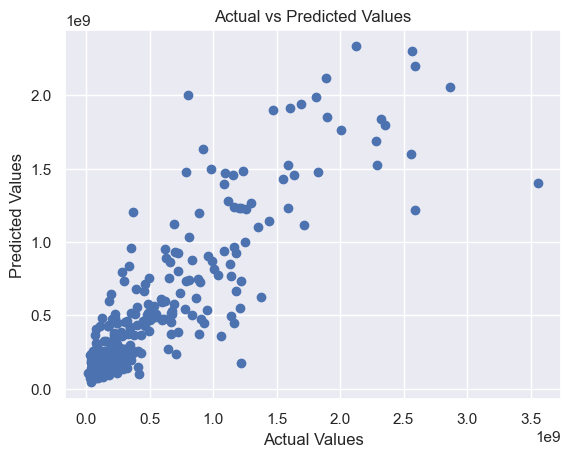

In [269]:
# Create a scatterplot of the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

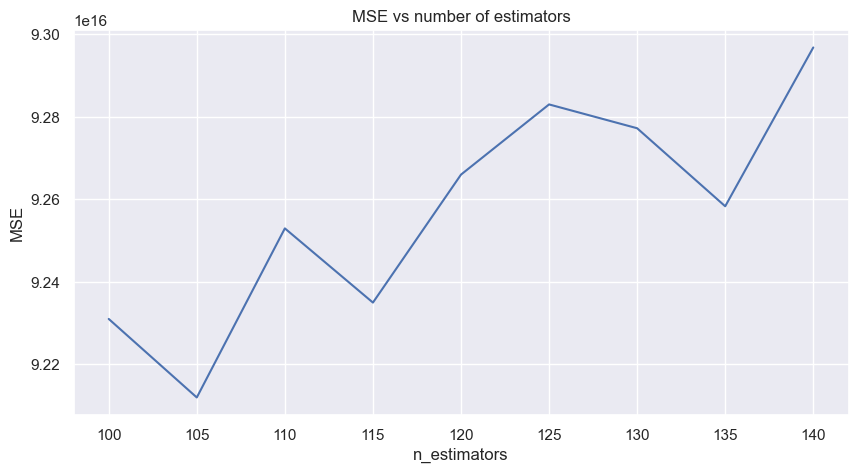

In [270]:
# Plot accuracy scores with different n_estimators
plt.figure(figsize=(10, 5))
plt.plot(list(accuracy_scores.keys()), list(accuracy_scores.values()))
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('MSE vs number of estimators')
plt.show()

## Evaluating the Random Forest Regression Model #

Compared to our other models, our Random Forest Regressor appears to initially be the most promising. It has the best metrics with the lowest mse of the 3 models and a .74 r-squared value. We were able to improve the model by tuning the number of estimators, as shown in the graph above. We found that 105 estimators yielded the best results. 

## Support Vector Machines ##

In [273]:
from sklearn.metrics import make_scorer, mean_squared_error

X   = df[['in_spotify_playlists', 'released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%']] #get the input features
y   = df['streams']              #get the target

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=SEED, #reproduce the results
                                                   )

X_train = X_train.copy()
X_test  = X_test.copy()

# Feature Scaling
scaler = StandardScaler()
scaler.fit(X_train[['in_spotify_playlists', 'released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%']])

# Apply the scaler to the X training data
X_train[['in_spotify_playlists', 'released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%']] = scaler.transform(X_train[['in_spotify_playlists','released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%']]) #scale the training data

#initialize the classifier

params = {'C': np.arange(1, 10),
         'gamma': np.arange(1, 5)}

svm = SVR() #the default kernel is rbf

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5, scoring=mse_scorer)
svm_grid.fit(X_train, y_train)

print(svm_grid.best_params_) #print the best parameters
print(svm_grid.best_score_)  #print the best score

# Make predictions on the test set with the best parameters
y_pred = svm_grid.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Get the r-squared value
r_squared = r2_score(y_test, y_pred)

print("MSE of the best model: ", mse)
print("R-Squared of the best model: ", r_squared)


{'C': 9, 'gamma': 1}
-3.480859429627168e+17
MSE of the best model:  4.2992630100065517e+17
R-Squared of the best model:  -0.19281068871971363


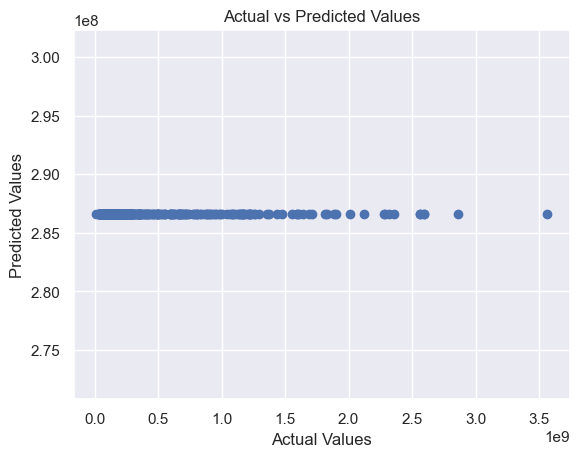

In [272]:
# Create a scatterplot of the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Conclusion ##

After testing all three models, it was concluded that the Random Forest Regressor yielded the most optimal results with both the lowest MSE and highest r-squared values. Still, the best results were quite surprising. The Random Forest Regressor Model, with tuning, provided an extremely high MSE value of roughly 9.2e16, but an optimal r2 value of roughly 0.75. If you evaluate the root mean square error (RMSE) we see that the square root of the average squared differences between the predicted values and the actual values is roughly 303 million streams.
The n estimators value that performed the best was 105, which we think is likely due to how important in_spotify_playlists is compared to the rest of our exmplanatory variables. 
